In [125]:
import os
import random
from typing import List, Tuple
import torchaudio
import matplotlib.pyplot as plt
import torch
from typing import Any, Optional
import numpy as np
from scipy import signal
from speechbrain.augment.time_domain import Resample
from IPython.display import Audio, display

def resample_audios(
    waveform: torch.Tensor,
    sampling_rate: int,
    resample_rate: int,
    lowcut: Optional[float] = None,
    order: int = 4,
) -> torch.Tensor:
    """Resamples a list of audio signals to a given sampling rate.

    Args:
        waveform (torch.Tensor): Audio waveform tensor.
        sampling_rate (int): Original sampling rate.
        resample_rate (int): Target sampling rate.
        lowcut (float, optional): Low cut frequency for IIR filter.
        order (int, optional): Order of the IIR filter. Defaults to 4.

    Returns:
        torch.Tensor: Resampled audio tensor.
    """
    if lowcut is None:
        lowcut = resample_rate / 2 - 100
    sos = signal.butter(order, lowcut, btype="low", output="sos", fs=resample_rate)

    channels = []
    for channel in waveform:
        filtered_channel = torch.from_numpy(signal.sosfiltfilt(sos, channel.numpy()).copy()).float()
        resampler = Resample(orig_freq=sampling_rate, new_freq=resample_rate)
        resampled_channel = resampler(filtered_channel.unsqueeze(0)).squeeze(0)
        channels.append(resampled_channel)

    resampled_waveform = torch.stack(channels)
    return resampled_waveform

def get_wav_files(folder: str) -> List[str]:
    """Get all .wav files in the given folder.

    Args:
        folder (str): The path to the folder.

    Returns:
        List[str]: A list of .wav file paths.
    """
    return [os.path.join(folder, file) for file in os.listdir(folder) if file.endswith('.wav')]

def pick_random_file(files: List[str]) -> str:
    """Pick a random file from the list of files.

    Args:
        files (List[str]): A list of file paths.

    Returns:
        str: The path to the randomly picked file.
    """
    return random.choice(files)

def load_audio(file_path: str) -> Tuple[torch.Tensor, int]:
    """Load the audio file using torchaudio.

    Args:
        file_path (str): The path to the audio file.

    Returns:
        Tuple[torch.Tensor, int]: The audio tensor and the sample rate.
    """
    waveform, sample_rate = torchaudio.load(file_path)

    return waveform, sample_rate

def extract_spectrogram_from_audio(
    waveform: torch.Tensor,
    n_fft: int = 1024,
    win_length: Optional[int] = None,
    hop_length: Optional[int] = None,
) -> torch.Tensor:
    """Extract spectrograms from an audio.

    Args:
        waveform (torch.Tensor): Audio waveform tensor.
        n_fft (int): Size of FFT, creates n_fft // 2 + 1 bins. Default is 1024.
        win_length (int): Window size. Default is None, using n_fft.
        hop_length (int): Length of hop between STFT windows. Default is None, using win_length // 2.

    Returns:
        torch.Tensor: spectrogram tensor.
    """
    if win_length is None:
        win_length = n_fft
    if hop_length is None:
        hop_length = win_length // 2
    spectrogram = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
    )
    try:
        return spectrogram(waveform).squeeze(0)
    except RuntimeError:
        return torch.tensor([])


def extract_mel_spectrogram_from_audio(
    waveform: torch.Tensor,
    sampling_rate: int,
    n_fft: Optional[int] = 1024,
    win_length: Optional[int] = None,
    hop_length: Optional[int] = None,
    n_mels: int = 128,
) -> torch.Tensor:
    """Extract mel spectrograms from a list of audio objects.

    Args:
        waveform (torch.Tensor): Audio waveform tensor.
        sampling_rate (int): Sampling rate of the audio.
        n_fft (int): Size of FFT, creates n_fft // 2 + 1 bins. Default is 1024.
        win_length (int): Window size. Default is None, using n_fft.
        hop_length (int): Length of hop between STFT windows. Default is None, using win_length // 2.
        n_mels (int): Number of mel filter banks. Default is 128.

    Returns:
        torch.Tensor: the mel spectrograms.
    """
    if win_length is None:
        win_length = n_fft
    if hop_length is None:
        if win_length is not None:
            hop_length = win_length // 2
        else:
            raise ValueError("win_length cannot be None")
    try:
        mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate=sampling_rate,
            n_fft=n_fft,
            win_length=win_length,
            hop_length=hop_length,
            n_mels=n_mels,
        )(waveform)
        return mel_spectrogram.squeeze(0)
    except RuntimeError:
        return torch.tensor([])


def plot_specgram(
    waveform: torch.Tensor,
    sampling_rate: int,
    mel_scale: bool = False,
    title: str = "Spectrogram",
    **spect_kwargs: Any,
) -> None:
    """Plots the spectrogram of an audio waveform.

    Args:
        waveform (torch.Tensor): The audio waveform tensor.
        sampling_rate (int): The sampling rate of the audio.
        mel_scale (bool): Whether to plot a mel spectrogram or a regular spectrogram.
        title (str): Title of the spectrogram plot.
        **spect_kwargs: Additional keyword arguments for spectrogram extraction.
    """

    def _power_to_db(
        spectrogram: np.ndarray, ref: float = 1.0, amin: float = 1e-10, top_db: float = 80.0
    ) -> np.ndarray:
        """Converts a power spectrogram to decibel (dB) units."""
        S = np.asarray(spectrogram)

        if amin <= 0:
            raise ValueError("amin must be strictly positive")

        if np.issubdtype(S.dtype, np.complexfloating):
            magnitude = np.abs(S)
        else:
            magnitude = S

        ref_value = np.abs(ref)
        log_spec = 10.0 * np.log10(np.maximum(amin, magnitude))
        log_spec -= 10.0 * np.log10(np.maximum(amin, ref_value))

        if top_db is not None:
            log_spec = np.maximum(log_spec, log_spec.max() - top_db)

        return log_spec

    # Extract the spectrogram
    if mel_scale:
        spectrogram = extract_mel_spectrogram_from_audio(waveform, sampling_rate, **spect_kwargs)
        y_axis_label = "Mel Frequency"
    else:
        spectrogram = extract_spectrogram_from_audio(waveform, **spect_kwargs)
        y_axis_label = "Frequency [Hz]"

    if spectrogram.ndim != 2:
        raise ValueError("Spectrogram must be a 2D tensor for plotting.")

    # Determine time and frequency scale
    num_frames = spectrogram.size(1)
    num_freq_bins = spectrogram.size(0)

    # Time axis in seconds
    time_axis = (waveform.size(-1) / sampling_rate) * (torch.arange(0, num_frames).float() / num_frames)

    # Frequency axis in Hz (for non-mel spectrograms)
    if mel_scale:
        freq_axis = torch.arange(num_freq_bins)  # For mel spectrogram, keep the bins as discrete values
    else:
        freq_axis = torch.linspace(0, sampling_rate / 2, num_freq_bins)

    plt.figure(figsize=(10, 4))
    plt.imshow(
        _power_to_db(spectrogram.numpy()),
        aspect="auto",
        origin="lower",
        extent=(float(time_axis[0]), float(time_axis[-1]), float(freq_axis[0]), float(freq_axis[-1])),
        cmap="viridis",
    )
    plt.colorbar(label="Magnitude (dB)")
    plt.title(title)
    plt.ylabel(y_axis_label)
    plt.xlabel("Time [Sec]")
    plt.show(block=False)

def play_audio(waveform: torch.Tensor, sampling_rate: int) -> None:
    """Plays an audio file.

    Args:
        waveform (torch.Tensor): The audio waveform tensor.
        sampling_rate (int): The sampling rate of the audio.

    Raises:
        ValueError: If the number of channels is more than 2.
    """
    waveform = waveform.numpy()
    sample_rate = sampling_rate

    num_channels = waveform.shape[0]
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")


In [130]:
from scipy.signal import butter, filtfilt
import torch

def high_pass_filter(waveform: torch.Tensor, sample_rate: int, cutoff_freq: float) -> torch.Tensor:
    """
    Applies a high-pass filter to an audio waveform.

    Args:
        waveform (torch.Tensor): Input audio waveform (1D or 2D Tensor).
        sample_rate (int): The sampling rate of the audio.
        cutoff_freq (float): The cutoff frequency of the high-pass filter in Hz.

    Returns:
        torch.Tensor: The filtered audio waveform.
    """
    if waveform.ndim == 2:
        # If waveform has multiple channels, process each channel independently
        filtered_waveform = torch.zeros_like(waveform)
        for i, channel in enumerate(waveform):
            filtered_waveform[i] = high_pass_filter(channel, sample_rate, cutoff_freq)
        return filtered_waveform

    # Normalize cutoff frequency to the Nyquist frequency
    nyquist = 0.5 * sample_rate
    normalized_cutoff = cutoff_freq / nyquist

    # Design the Butterworth high-pass filter
    b, a = butter(N=4, Wn=normalized_cutoff, btype='high', analog=False)

    # Apply the filter using filtfilt for zero-phase filtering
    filtered_waveform = filtfilt(b, a, waveform.numpy())

    # Make a copy of the filtered waveform to avoid negative strides
    filtered_waveform = filtered_waveform.copy()

    # Convert back to torch.Tensor
    return torch.tensor(filtered_waveform, dtype=waveform.dtype)

Randomly picked file: ../../data/ICBHI_final_database/labels/160_1b3_Lr_mc_AKGC417L.wav


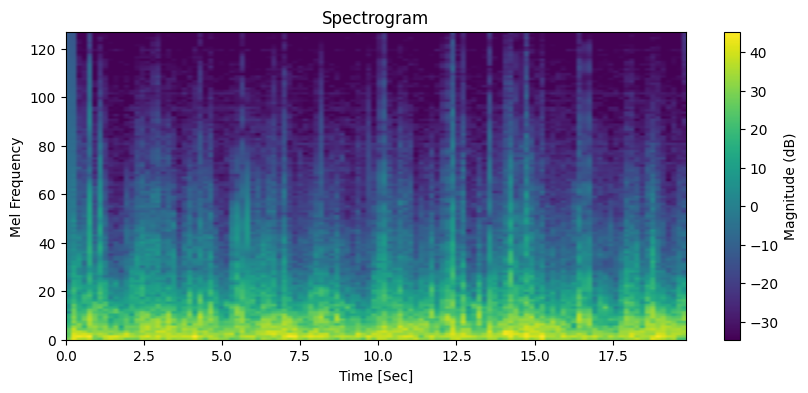

In [147]:
folder_path = '../../data/ICBHI_final_database/labels'
wav_files = get_wav_files(folder_path)
if wav_files:
    random_file = pick_random_file(wav_files)
    print(f"Randomly picked file: {random_file}")
    waveform, sample_rate = load_audio(random_file)
    new_sampling_rate = 3000 # Hz, clips recorded with Lit3200 show a blank space above 3kHz
    new_waveform = resample_audios(waveform, sample_rate, new_sampling_rate, order=5)
    # new_waveform = high_pass_filter(new_waveform, new_sampling_rate, cutoff_freq=100) # Hz
    plot_specgram(waveform=new_waveform, sampling_rate=new_sampling_rate, mel_scale=True)
    play_audio(waveform, sample_rate)
else:
    print("No .wav files found in the folder.")